HHU Deep Representation Learning, Prof. Dr. Markus Kollmann

Lecturers and Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 05 - Image Clustering
---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 30.05.2025 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/lfg71DbYxyyT8e6](https://uni-duesseldorf.sciebo.de/s/lfg71DbYxyyT8e6)

---
# Introduction 

Image clustering in deep learning can be mathematically described as a process of partitioning a set of images, X, into K clusters, where K is a user-defined parameter representing the number of desired clusters.

Let V(X) be the visual feature representation of the images in X, obtained using a deep learning algorithm such as a convolutional neural network (CNN). Each image in X is transformed into a feature vector in V(X), where the dimensions correspond to the learned features of the CNN.

Image clustering is a task in deep learning where an algorithm is used to group similar images together based on their visual characteristics. Ideally, images with similar ground truth labels will belong in the same cluster.

The goal of image clustering is to automatically categorize large sets of images into smaller subsets based on their similarities, which can help in organizing and managing large image datasets.

To accomplish this task, deep learning algorithms use complex mathematical models to analyze and identify patterns within the images, and then group the images that share these patterns into clusters. This process can be useful in a variety of applications, such as image recognition, image search, and content-based image retrieval.


[SimCLR Paper](https://arxiv.org/abs/2002.05709)

[MoCo Paper](https://arxiv.org/abs/1911.05722)

[SCAN Paper](https://arxiv.org/abs/2005.12320v2)




In [1]:
!wget -nc https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week05/utils.py

File ‘utils.py’ already there; not retrieving.




### Imports, basic utils, augmentations

In [2]:
import torchvision.models as models
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from torch.optim import Adam
from torch.utils.data import TensorDataset
from tqdm.auto import trange

# Local imports
from utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.mps.is_available() else "cpu")
num_workers = 0 if device.type == "mps" else os.cpu_count()

os.makedirs("./data/", exist_ok=True)
os.makedirs("./figs/", exist_ok=True)
os.makedirs("./models/", exist_ok=True)

# Task 1: Load the pretrained MoCO model ResNet50 pretrained on ImageNet

[Weights are available in this link](https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar)

You can download the weight by running the terminal command:

`$ wget link_to_model_weights`



In [4]:
!wget -nc -P ./models/ https://dl.fbaipublicfiles.com/moco/moco_checkpoints/moco_v2_800ep/moco_v2_800ep_pretrain.pth.tar

File ‘./models/moco_v2_800ep_pretrain.pth.tar’ already there; not retrieving.



In [5]:
def load_moco_model(pretrained_path="./models/moco_v2_800ep_pretrain.pth.tar"):
    ### START CODE HERE ### (≈ 12 lines of code)
    model = models.resnet50()
    model.fc = nn.Identity()

    weights = torch.load(pretrained_path, map_location="cpu")
    message = model.load_state_dict({
        k.replace("module.encoder_q.", ""): v
        for k, v in weights["state_dict"].items()
        if not k.startswith("module.encoder_q.fc")
    }, strict=False)
    print("Loaded model with message:", message)
    ### END CODE HERE ###
    model.eval()
    return model


encoder = load_moco_model()

Loaded model with message: <All keys matched successfully>


### Expected results

There should be no missing keys, while loading the model. There may be some unexpected keys based on your implementation.

```python
Loaded model with message: _IncompatibleKeys(missing_keys=[], unexpected_keys=["fc.0.weight", "fc.0.bias", "fc.2.weight", "fc.2.bias"])
```

## Task 2: Compute the k-means clustering accuracy using the learned representations


Compute the accuracy both for the train and test split using k-means.

- You can pre-compute the image feature representations
- Use the labelled data of STL10 (train split).
- Hint: you may use the function "compute_clustering_metrics" defined in `utils.py``


In [6]:
### START CODE HERE ### (>10 lines of code)
train_dl, val_dl = load_data(train_split="train", num_workers=num_workers)

In [7]:
feats_and_labels_path = "./data/moco_feats_and_labels.pth"

if os.path.exists(feats_and_labels_path):
    data = torch.load(feats_and_labels_path)
    train_feats, train_labels = data["train_feats"], data["train_labels"]
    val_feats, val_labels = data["val_feats"], data["val_labels"]
else:
    train_feats, train_labels = get_features(encoder, train_dl, device)
    val_feats, val_labels = get_features(encoder, val_dl, device)

    torch.save({
        "train_feats": train_feats,
        "train_labels": train_labels,
        "val_feats": val_feats,
        "val_labels": val_labels
    }, feats_and_labels_path)

In [8]:
kmeans = lambda: KMeans(10, random_state=42)
train_preds = kmeans().fit(train_feats).labels_
val_preds = kmeans().fit(val_feats).labels_

In [9]:
train_acc, *_ = compute_clustering_metrics(train_labels, train_preds, min_samples_per_class=10)
val_acc, *_ = compute_clustering_metrics(val_labels, val_preds, min_samples_per_class=10)

print(f"Train Accuracy: {train_acc:.2f} | Validation Accuracy: {val_acc:.2f}")
### END CODE HERE ###

Train Accuracy: 38.86 | Validation Accuracy: 43.76


### Expected results

`Train acc: 55.86, Val acc: 55.86`

Results may vary due to random initialization!

### Task 3: T-SNE visualization of features

As in the previous exercise, check the results of linear probing on the supervised training split and the T-SNE visualization.

Code for the T-SNE visualization exists in `utils.py`.

In [10]:
### START CODE HERE ### ( 3 line of code)
dl = lambda *args: DataLoader(TensorDataset(*args), batch_size=256)
train_feat_dl = dl(train_feats, train_labels)
val_feat_dl = dl(val_feats, val_labels)

In [11]:
num_epochs = 100
model = nn.Linear(2048, 10)
optimizer = Adam(model.parameters(), lr=0.001)
log = linear_eval(model, optimizer, num_epochs, train_feat_dl, val_feat_dl, device)

print(f"Best Train Accuracy: {max(log["train_acc_epoch"]):.2f} | Best Validation Accuracy: {max(log["val_acc_epoch"]):.2f}")

Init Accuracy of the model: Train:10.340 	 Val:10.887500


  0%|          | 0/100 [00:00<?, ?it/s]

Best Train Accuracy: 91.30 | Best Validation Accuracy: 87.44


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.003s...


/opt/homebrew/anaconda3/envs/representation-learning/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5000 samples in 0.620s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.152693
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.571846
[t-SNE] KL divergence after 2000 iterations: 1.561150


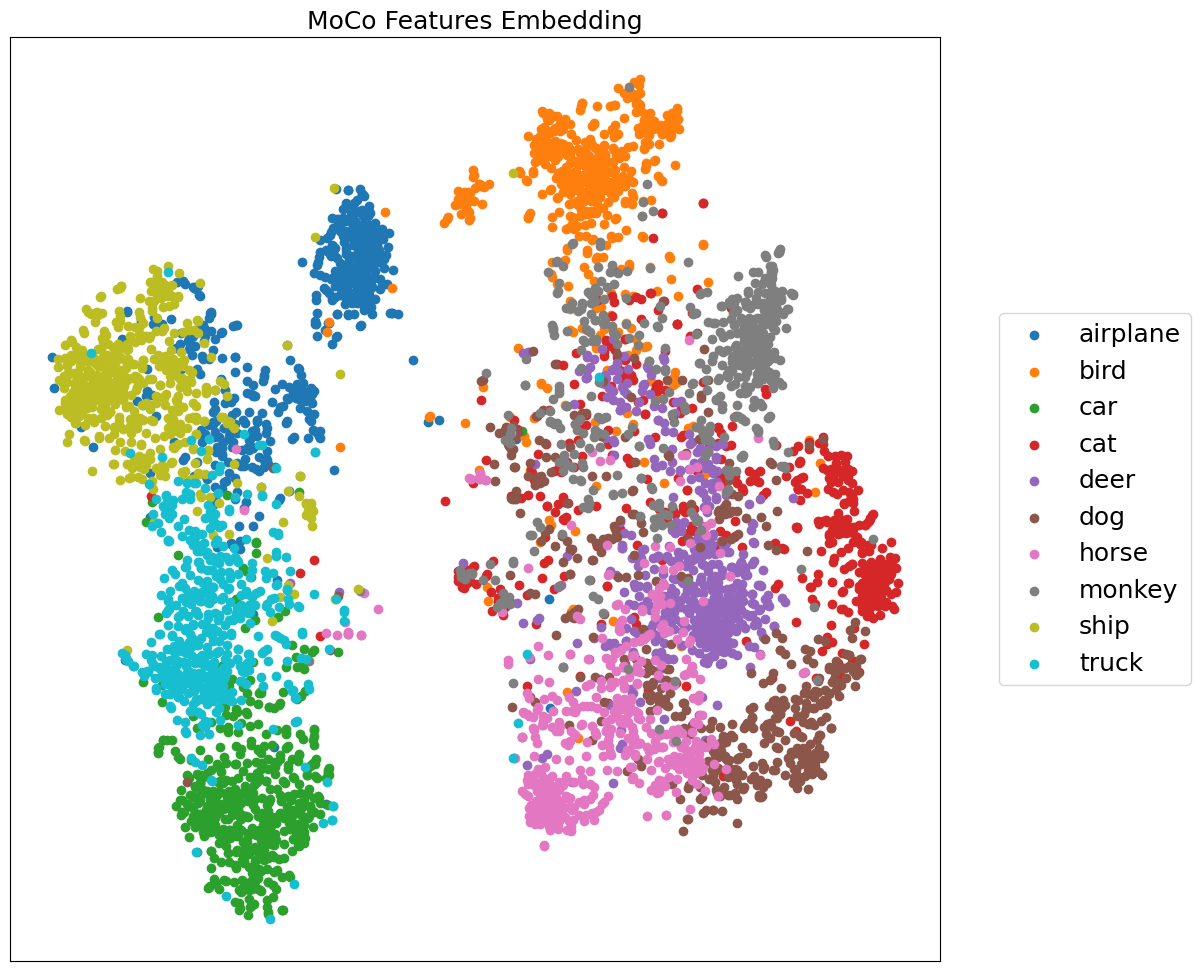

In [12]:
tsne_plot_embeddings(train_feats, train_labels, train_dl.dataset.classes, "MoCo Features Embedding")
### END CODE HERE ###

## Expected result
![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week05/figs/tsne_plot_embeddings_solution.png)

### Task 4: Compute the k=50 nearset neiboughrs on the feature space of the pretrained ResNet50

- Use the cosine similarity
- Visualize the top 5 NN for a couple of images

<Figure size 640x480 with 0 Axes>

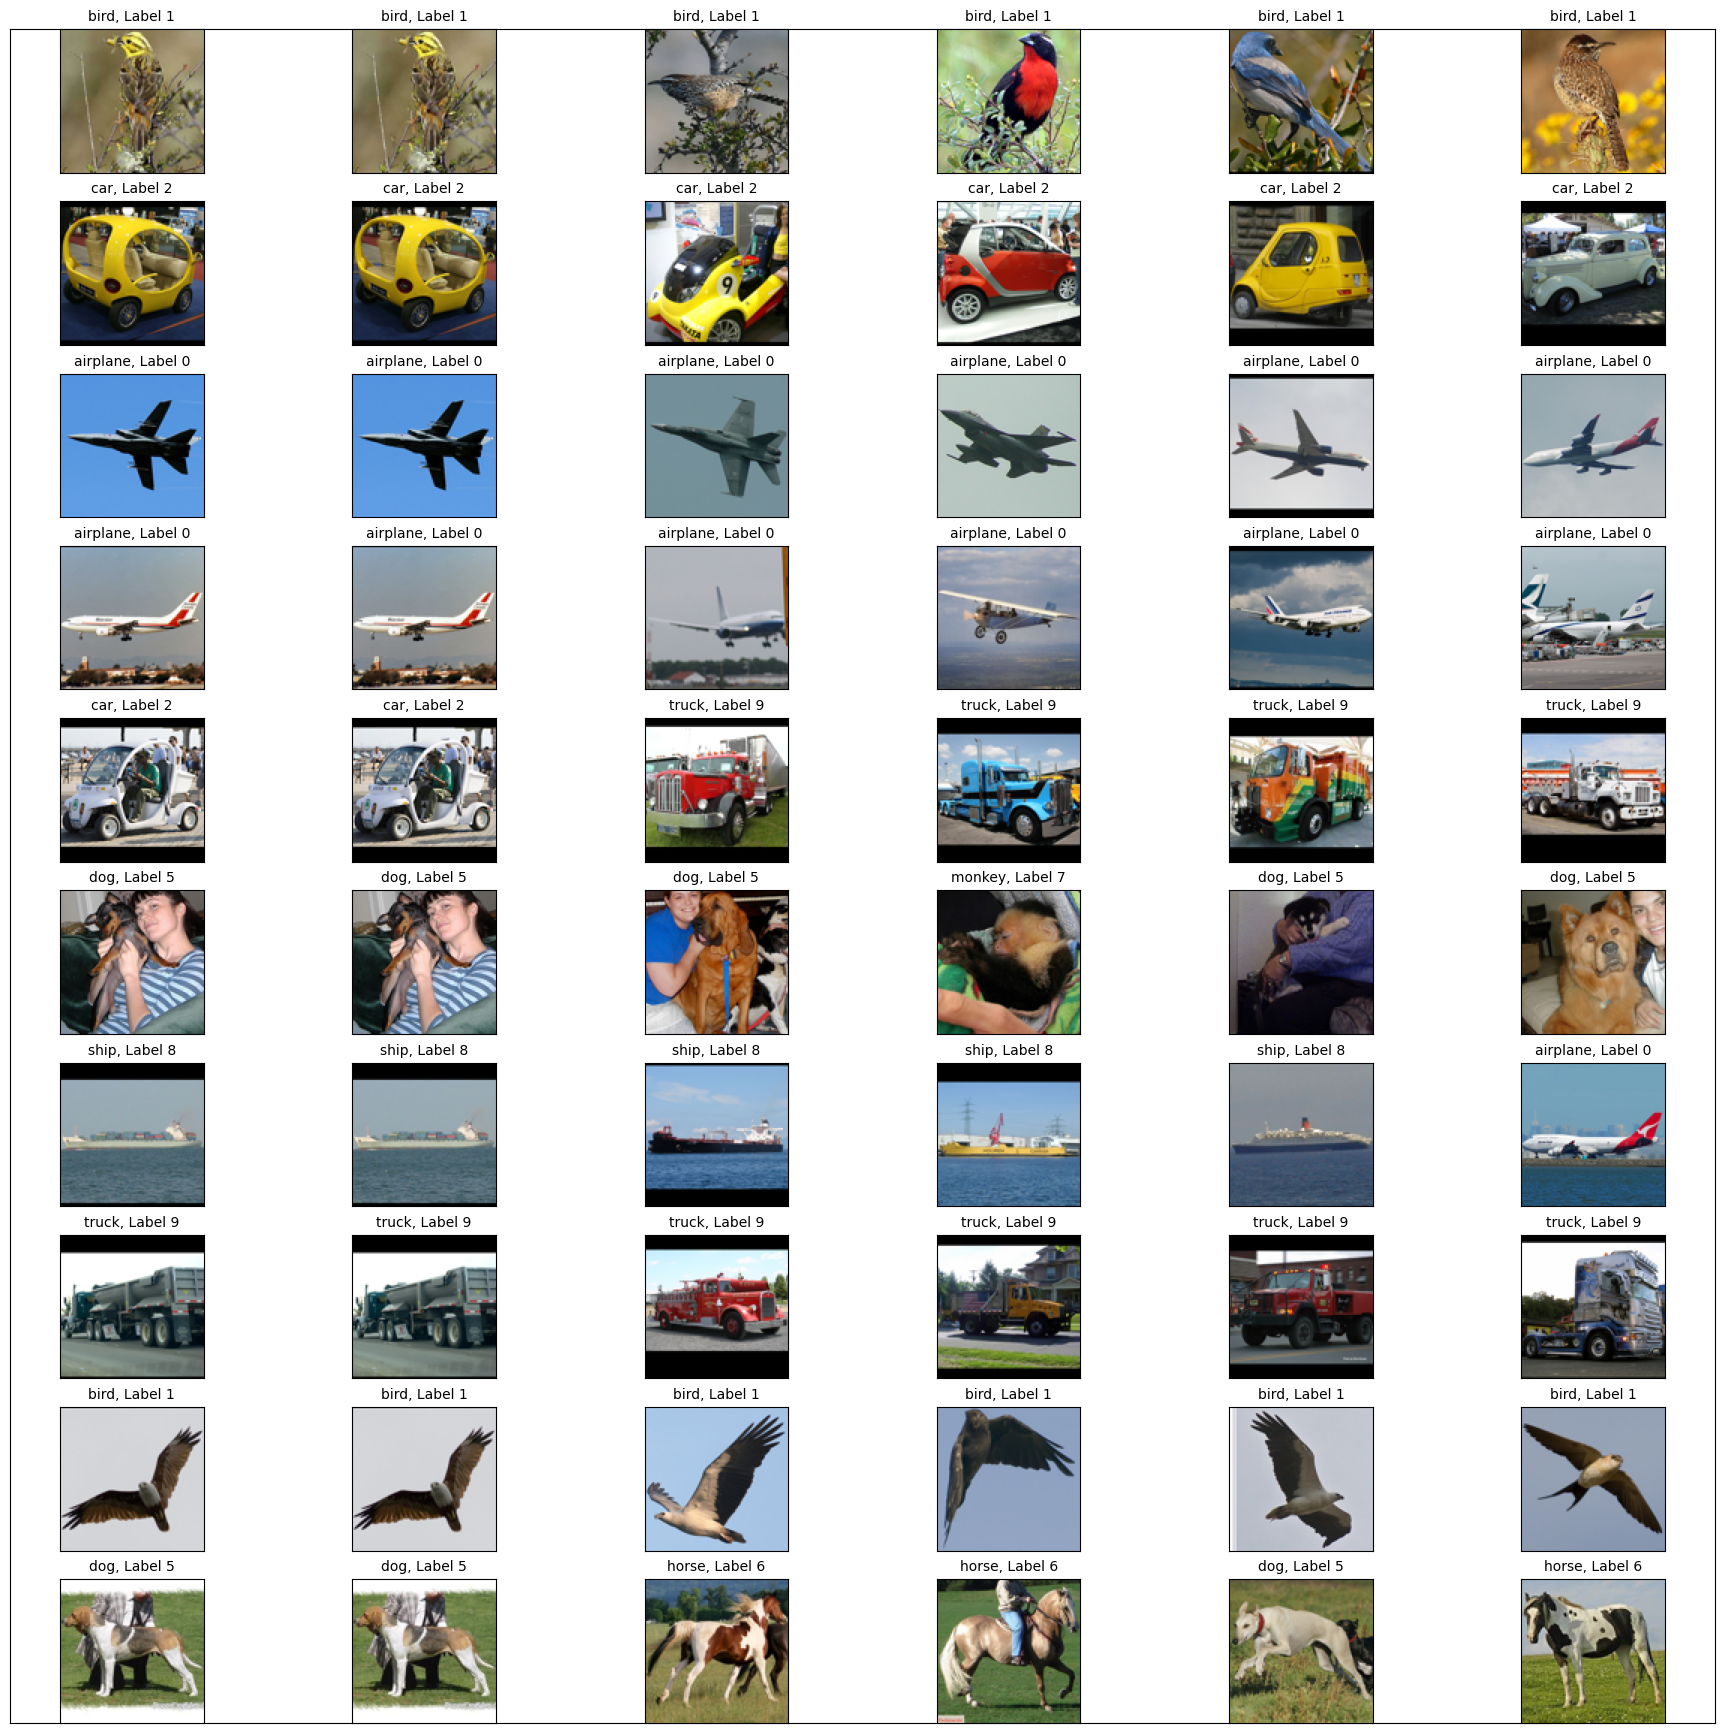

In [13]:
# Provided
class_names = train_dl.dataset.classes


def vizualize_pairs(indices, true_labels, train_ds):
    # Visualize the reference image and its 7 nearest neighbors
    ref_ids = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    nn_viz = 6
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.figure(figsize=(22, 22))
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for c, ref in enumerate(ref_ids):
        knns = indices[ref, :nn_viz]
        imgs_to_viz = [train_ds[ref][0]]
        true_labels = [train_ds[ref][1]]
        for i in knns:
            imgs_to_viz.append(train_ds[i][0])
            true_labels.append(train_ds[i][1])
        # show the images
        for j in range(nn_viz):
            label = int(true_labels[j])
            plt.subplot(len(ref_ids), nn_viz, (c * nn_viz) + (j + 1))
            imshow(imgs_to_viz[j])
            plt.title(f"{class_names[label]}, Label {label}", fontsize=10)
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.savefig(f"./figs/knn_viz", bbox_inches="tight", dpi=500)
    plt.show()


### START CODE HERE ### ( 7-8 line of code)
k = 50
knn_indices_path = "./data/knn_indices.pth"

if os.path.exists(knn_indices_path):
    indices = torch.load(knn_indices_path)
else:
    nearest_neighbors = NearestNeighbors(n_neighbors=k, metric="cosine")
    nearest_neighbors.fit(train_feats)
    distances, indices = nearest_neighbors.kneighbors(train_feats)
    indices = torch.as_tensor(indices)

    torch.save(indices, knn_indices_path)

vizualize_pairs(indices, train_labels, train_dl.dataset)
### END CODE HERE ###

## Expected result

![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week05/figs/knn_viz.png)

### Task 5: Write a new dataset class to load image pairs

In [14]:
class PairSTL10(torch.utils.data.Dataset):
    def __init__(self, indices_path=knn_indices_path, embeds_path=feats_and_labels_path, l2_normalize=True):
        ### START CODE HERE ###
        self.data = torch.load(embeds_path)["train_feats"]
        self.indices = torch.load(indices_path)

        self.l2_normalize = l2_normalize
        ### END CODE HERE ###

    def __getitem__(self, idx):
        ### START CODE HERE ###
        nn_idx = self.indices[idx][0]
        emb1, emb2 = self.data[idx], self.data[nn_idx]
        if self.l2_normalize:
            emb1 = F.normalize(emb1, dim=0)
            emb2 = F.normalize(emb2, dim=0)
        return emb1, emb2
        ### END CODE HERE ###

    def __len__(self):
        return len(self.data)


def test_get_pair():
    dataset = PairSTL10()
    emb1, emb2 = dataset[16]
    print(emb1.shape, emb2.shape)
    assert emb1.shape == emb2.shape


test_get_pair()

train_dl = torch.utils.data.DataLoader(PairSTL10(), batch_size=128, shuffle=True, num_workers=num_workers)
data_batch = next(iter(train_dl))
print(data_batch[0].shape, data_batch[1].shape)

torch.Size([2048]) torch.Size([2048])
torch.Size([128, 2048]) torch.Size([128, 2048])


## Expected result

```
torch.Size([2048]) torch.Size([2048])
torch.Size([128, 2048]) torch.Size([128, 2048])
```

### Task 6: Implement the SCAN loss. Train the clustering head and compute the validation accuracy.
Paper: https://arxiv.org/abs/2005.12320 (semantic clustering loss)

In [15]:
class SCAN(torch.nn.Module):
    def __init__(self, alpha=1):
        super().__init__()
        self.alpha = alpha

    def forward(self, proj_1, proj_2):
        ### START CODE HERE ### (≈ 5 lines of code)
        p1, p2 = proj_1.softmax(dim=1), proj_2.softmax(dim=1)
        sim_loss = -(p1 * p2).sum(dim=1).log().mean()

        mean_p = p1.mean(dim=0)
        entropy_loss = (mean_p * mean_p.log()).sum()
        ### END CODE HERE ###
        return sim_loss + self.alpha * entropy_loss


def test_scan():
    torch.manual_seed(99)
    scan = SCAN(alpha=1)
    proj_1 = torch.randn(100, 128)
    proj_2 = torch.randn(100, 128)
    loss = scan(proj_1, proj_2)
    print(loss)
    assert loss.shape == torch.Size([])


test_scan()

tensor(0.0275)


### Expected results

For alpha=1, output = `tensor(0.0275)`

### Task 7: Implement the PMI loss. 
Paper: https://arxiv.org/abs/2303.17896 (Section 3, Equation 8)
- Typically methods have multiple clustering heads. We use just one here!

In [16]:
class PMI(torch.nn.Module):
    def __init__(self, gamma=1, momentum=0.99, temp=0.1):
        super().__init__()
        self.gamma = gamma
        self.temp = temp
        self.center = None
        self.momentum = momentum

    def forward(self, proj_1, proj_2):
        ### START CODE HERE ###
        p1, p2 = (proj_1 / self.temp).softmax(dim=1), (proj_2 / self.temp).softmax(dim=1)
        self.update_ema(p1)
        pmi_loss = self.pmi(p1, p2, self.center)
        ### END CODE HERE ###
        return pmi_loss

    def pmi(self, p1, p2, pk):
        ### START CODE HERE ###
        return -((p1 * p2) ** self.gamma / pk).sum(dim=1).log().mean()
        ### END CODE HERE ###

    @torch.no_grad()
    def update_ema(self, output):
        """
        Update exponential moving average.
        """
        batch_center = output.detach().mean(dim=0)
        if self.center is None:
            # Initialize center uniformly
            self.center = torch.ones_like(batch_center) / batch_center.size(0)
        ### START CODE HERE ### (1 line of code)
        self.center = self.momentum * self.center + (1 - self.momentum) * batch_center
        ### END CODE HERE ###


def test_pmi():
    torch.manual_seed(99)
    criterion = PMI(gamma=1)
    proj_1 = torch.rand(100, 128)
    proj_2 = torch.rand(100, 128)
    loss = criterion(proj_1, proj_2)
    print(loss)
    assert loss.shape == torch.Size([])


test_pmi()

tensor(0.0737)


### Expected results 

`tensor(0.0738)`

### Task 8: Modify pretraining code

- The previous training code will not work out of the box since now we load image pairs that are nearest neiboughrs in feature space.


In [17]:
import copy


class EMA():
    def __init__(self, alpha, student):
        super().__init__()
        self.alpha = alpha
        self.teacher = copy.deepcopy(student)
        for p in self.teacher.parameters():
            p.requires_grad = False

    def update_average(self, old, new):
        if old is None:
            return new
        ### START CODE HERE ###
        return self.alpha * old + (1 - self.alpha) * new
        ### END CODE HERE ###

    def update_teacher(self, student):
        for ema_params, student_params in zip(self.teacher.parameters(), student.parameters()):
            old_weight, student_weight = ema_params.data, student_params.data
            ema_params.data = self.update_average(old_weight, student_weight)


def pretrain_one_epoch(model, optimizer, train_dl, criterion, device, model_ema=False):
    """
    Args:
        model_ema (bool, optional): Whether we use  an exponential moving 
        average for the second image/view. If false both images/views share the same
        feature extractor. Defaults to False.
    Returns:
        the mean loss of the current epoch
    """
    ### START CODE HERE ### (≈ 12 lines of code)

    proj2_model = model
    if model_ema:
        ema = EMA(alpha=0.99, student=model)
        proj2_model = ema.teacher

    model.train()
    loss_curr_epoch = 0
    for data, target in tqdm(train_dl, desc="Batch", unit="batch", leave=False):
        emb1, emb2 = data.to(device), target.to(device)

        proj_1 = model(emb1)
        proj_2 = proj2_model(emb2)

        loss = criterion(proj_1, proj_2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_curr_epoch += loss.item()

    ### END CODE HERE ###
    return loss_curr_epoch


# This will be given to the students
def pretrain(model, optimizer, num_epochs, train_dl, criterion, device, prefix="scan", model_ema=False):
    dict_log = {"train_loss": []}
    best_loss = 1e8
    model = model.to(device)
    pbar = trange(num_epochs, desc="Epoch")
    for epoch in pbar:
        loss_curr_epoch = pretrain_one_epoch(model, optimizer, train_dl, criterion, device, model_ema=model_ema)
        msg = (f"Ep {epoch}/{num_epochs}: || Loss: Train {loss_curr_epoch:.3f}")
        pbar.set_description(msg)
        dict_log["train_loss"].append(loss_curr_epoch)
        if loss_curr_epoch < best_loss:
            best_loss = loss_curr_epoch
            save_model(model, f"./models/{prefix}_best_model_min_val_loss.pth", epoch, optimizer, best_loss)
    return dict_log

### Task 9: Train with SCAN and PMI using the KNN pairs

Train the clustering head (a small MLP) and compute the validation accuracy for both methods.

In [18]:
dataset = PairSTL10(indices_path=knn_indices_path, embeds_path=feats_and_labels_path, l2_normalize=True)
train_dl = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=num_workers)
criterion = SCAN(alpha=10)
n_clusters = 10
num_epochs = 150


def get_mlp(n_clusters=10):
    ### START CODE HERE
    return torch.nn.Sequential(
        torch.nn.Linear(2048, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, n_clusters))
    ### END CODE HERE


# SCAN
scan_head = get_mlp(n_clusters=n_clusters)
optimizer = torch.optim.Adam(scan_head.parameters(), lr=1e-4, weight_decay=1e-6)
dict_log_scan = pretrain(scan_head, optimizer, num_epochs, train_dl, criterion, device, prefix="scan")

# PMI
criterion = PMI(gamma=0.65, momentum=0.9, temp=0.1)
pmi_head = get_mlp(n_clusters=n_clusters)
optimizer = torch.optim.Adam(pmi_head.parameters(), lr=1e-4, weight_decay=1e-6)
dict_log_pmi = pretrain(pmi_head, optimizer, num_epochs, train_dl, criterion, device, prefix="pmi", model_ema=True)

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Epoch:   0%|          | 0/150 [00:00<?, ?it/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

Batch:   0%|          | 0/20 [00:00<?, ?batch/s]

### Task 10: Get cluster assignments and evaluate cluster accuracy

- The code you need to fill loads the feature and computes the logits (unnormalized output of the trained clustering head)
- For details on how to preprocess the data, you need to mimic the training data pipeline.


In [19]:
@torch.no_grad()
def evaluate_clustering(model, feats_and_labels_path=feats_and_labels_path):
    model.eval()
    data = torch.load(feats_and_labels_path)
    val_feats, val_labels = data["val_feats"], data["val_labels"]
    train_feats, train_labels = data["train_feats"], data["train_labels"]

    ### START CODE HERE
    train_feats = F.normalize(train_feats, dim=-1, p=2)
    val_feats = F.normalize(val_feats, dim=-1, p=2)
    train_dataset = torch.utils.data.TensorDataset(train_feats, train_labels)
    val_dataset = torch.utils.data.TensorDataset(val_feats, val_labels)

    train_feat_dl = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=False)
    val_feat_dl = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)
    train_logits, _ = get_features(model, train_feat_dl, device)
    val_logits, _ = get_features(model, val_feat_dl, device)
    ### END CODE HERE

    train_preds = train_logits.argmax(dim=-1).cpu().numpy()
    val_preds = val_logits.argmax(dim=-1).cpu().numpy()
    print("Unique preds", np.unique(train_preds), np.unique(val_preds))
    #assert len(np.unique(train_preds)) == n_clusters , "Collapse! Number of predicted assignments is not equal to number of clusters"

    metrics_train = compute_clustering_metrics(train_labels.cpu().numpy(), train_preds, min_samples_per_class=10)
    metrics_val = compute_clustering_metrics(val_labels.cpu().numpy(), val_preds, min_samples_per_class=10)
    return metrics_train[0], metrics_val[0]


n_clusters = 10
model = get_mlp(n_clusters=n_clusters)
model_scan = load_model(model, "./models/scan_best_model_min_val_loss.pth")

model = get_mlp(n_clusters=n_clusters)
model_pmi = load_model(model, "./models/pmi_best_model_min_val_loss.pth")
train_acc, val_acc = evaluate_clustering(model_scan)
print(f"SCAN: Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")
train_acc, val_acc = evaluate_clustering(model_pmi)
print(f"PMI: Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

Model ./models/scan_best_model_min_val_loss.pth is loaded from epoch 147 , loss -450.9131450653076
Model ./models/pmi_best_model_min_val_loss.pth is loaded from epoch 67 , loss -45.614018201828
Unique preds [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]
SCAN: Train acc: 53.520, Val acc: 53.663
Unique preds [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]
PMI: Train acc: 59.880, Val acc: 60.413


### Expected results:
Current best scores!
```
Model ./scan_best_model_min_val_loss.pth is loaded from epoch 148 , loss -22.383880043029784
Model ./pmi_best_model_min_val_loss.pth is loaded from epoch 129 , loss -2.0719790697097777
Unique preds [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]
SCAN: Train acc: 74.380, Val acc: 74.450
Unique preds [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]
PMI: Train acc: 77.280, Val acc: 78.238
```

# Conclusion 

That"s the end of this exercise. If you reached this point, congratulations!
